In [1]:
%load_ext autoreload
%autoreload 2

In [130]:
import os
import argparse
import numpy as np
import json

import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import networkx as nx
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

from minimal.arch import Generator

from minimal.dataset import (
    FloorplanGraphDataset,
    floorplan_collate_fn,
    reader,
    one_hot_embedding,
    floorplan_collate_fn
)

from minimal.utils import (
    init_input,
    draw_masks,
    draw_graph
)

%matplotlib inline

In [3]:
data_path = "./data/sample_list.txt"
transform = transforms.Normalize(mean=[0.5], std=[0.5])
target_set = 8
split = "test"

In [4]:
with open("data/expr.json") as f:
    info = json.load(f)

In [5]:
# read from file

# rms_type: "room_type" from file
# rms_bbs: (12, 4): "boxes" from file, but centralized
# fp_eds: (54, 4): "edges" from file, but centralized
# eds_to_rms: list[list[int]] "ed_rm" from file
# eds_to_rms_tmp: eds_to_rms but the inner list truncated to length 1
#                 i.e eds_to_rms_tmp[i][0] == eds_to_rms[i][0] for every i

rms_type = info["room_type"]
rms_bbs_j = np.array(info["boxes"])
fp_eds_j = np.array(info["edges"])[:, :4]
eds_to_rms = info["ed_rm"]

In [6]:
# convert bounding boxes from range [0,256] to range [0,1]
rms_bbs_01 = rms_bbs_j / 256.0
fp_eds_01 = fp_eds_j / 256.0

In [7]:
# discard last 2 number of fp_eds
# new shape: (*, 4)
print(fp_eds_01.shape)

(54, 4)


In [8]:
# (R, 2)
rooms_top_lefts = rms_bbs_01[:, :2]
rooms_btm_rights = rms_bbs_01[:, 2:]

# top left of the bounding box of the masks
global_tl = np.min(rooms_top_lefts, axis=0)
# bottom right of the bounding box of the masks
global_br = np.max(rooms_btm_rights, axis=0)

In [15]:
# Make the center of the overall bounding box (0.5, 0.5)
# i.e centralize the floor plan 

rms_bbs = np.zeros_like(rms_bbs_01)
fp_eds = np.zeros_like(fp_eds_01)

shift = (global_tl + global_br) / 2.0 - 0.5

rms_bbs[:, :2] = rms_bbs_01[:, :2] - shift
rms_bbs[:, 2:] = rms_bbs_01[:, 2:] - shift
fp_eds[:, :2] = fp_eds_01[:, :2] - shift
fp_eds[:, 2:] = fp_eds_01[:, 2:] - shift

In [69]:
def make_sequence(edges):
    polys = []
    
    v_curr = tuple(edges[0][:2])
    e_ind_curr = 0
    e_visited = [0]
    seq_tracker = [v_curr]
    find_next = False

    while len(e_visited) < len(edges):
        if find_next == False:
            if v_curr == tuple(edges[e_ind_curr][2:]):
                v_curr = tuple(edges[e_ind_curr][:2])
            else:
                v_curr = tuple(edges[e_ind_curr][2:])
            find_next = True
        else:
            # look for next edge
            for k, e in enumerate(edges):
                if k not in e_visited:
                    if v_curr == tuple(e[:2]):
                        v_curr = tuple(e[2:])
                        e_ind_curr = k
                        e_visited.append(k)
                        break
                    elif v_curr == tuple(e[2:]):
                        v_curr = tuple(e[:2])
                        e_ind_curr = k
                        e_visited.append(k)
                        break

        # extract next sequence
        if v_curr == seq_tracker[-1]:
            polys.append(seq_tracker)
            for k, e in enumerate(edges):
                if k not in e_visited:
                    v_curr = tuple(edges[0][:2])
                    seq_tracker = [v_curr]
                    find_next = False
                    e_ind_curr = k
                    e_visited.append(k)
                    break
        else:
            seq_tracker.append(v_curr)
    polys.append(seq_tracker)

    return polys

In [125]:
rms_masks = []
im_size = 256
out_size = 64
fp_mk = np.zeros((out_size, out_size))

In [126]:
nodes = rms_type

In [127]:
for k in range(len(nodes)):

    # add rooms and doors
    # eds = []
    # for l, e_map in enumerate(eds_to_rms_tmp):
    #     if k == e_map[0]:
    #         eds.append(l)

    # Index of edges from eds_to_rms which have node k as their first node
    eds = [i for i, inner in enumerate(eds_to_rms) if inner[0] == k]
        
    edges = fp_eds[eds]
    poly = make_sequence(edges)[0]
    poly = [(im_size * x, im_size * y) for x, y in poly]

    rm_im = Image.new("L", (im_size, im_size))

    if len(poly) >= 2:
        ImageDraw \
            .Draw(rm_im) \
            .polygon(poly, fill="white")
    else:
        print("Empty room")
        exit(0)

    rm_im = rm_im.resize((out_size, out_size))
    rm_arr = np.array(rm_im)
    inds = np.where(rm_arr > 0)
    rm_arr[inds] = 1.0
    rms_masks.append(rm_arr)

    if rms_type[k] != 15 and rms_type[k] != 17:
        fp_mk[inds] = k + 1

# trick to remove overlap
for k in range(len(nodes)):
    if rms_type[k] != 15 and rms_type[k] != 17:
        rm_arr = np.zeros((out_size, out_size))
        inds = np.where(fp_mk == k + 1)
        rm_arr[inds] = 1.0
        rms_masks[k] = rm_arr

rms_masks = np.array(rms_masks)

In [164]:
graph_nodes = torch.FloatTensor(one_hot_embedding(np.array(rms_type))[:, 1:])
graph_edges = torch.LongTensor(triples)
# transform convert range [0, 1] to [-1, 1]
rooms_mks = transform(torch.FloatTensor(rms_masks))
sample = (rooms_mks, graph_nodes, graph_edges)

In [166]:
a, b, c, d, e = floorplan_collate_fn([sample])

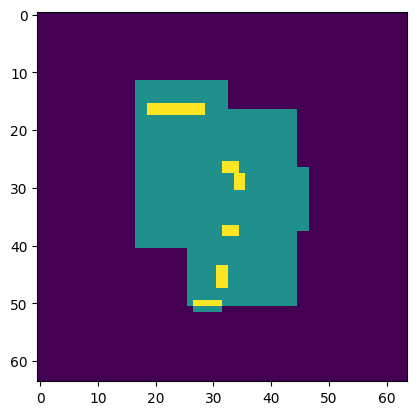

In [174]:
plt.imshow(rooms_mks.sum(0))